# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [1]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder

# Data Loading

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([32, 32])


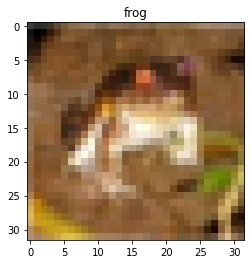

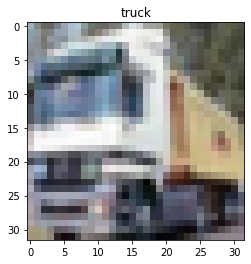

In [5]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################
from matplotlib import pyplot as plt

def imshow(img: torch.Tensor, label: str):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np_img)
    plt.title(label)
    plt.show()

dataiter = iter(train_dataset)
images, labels = dataiter.__next__()
print("Image shape: ", images[0].shape)
imshow(images.permute(1, 2, 0), train_dataset.classes[labels])

images, labels = dataiter.__next__()
imshow(images.permute(1, 2, 0), train_dataset.classes[labels])
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

In [8]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################
print(train_dataset.__dict__.keys())
print(f"There are {len(train_dataset)} samples in the train set\nThere are {len(test_dataset)} samples in the test set")
num_labels = len(train_dataset.classes)
print(f"Total Number of labels: {num_labels}")
print()
print(f"Classes and their labels: {train_dataset.class_to_idx}")
print()
num_train_samples_per_label = [(train_dataset.classes[label], count) for label, count in 
                                    zip(*np.unique(train_dataset.targets, return_counts=True))]
num_test_samples_per_label = [(test_dataset.classes[label], count) for label, count in 
                                    zip(*np.unique(test_dataset.targets, return_counts=True))]
print(f'Samples per label - train dataset:\n{num_train_samples_per_label}')
print()
print(f'Samples per label - test dataset:\n{num_test_samples_per_label}')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])
There are 50000 samples in the train set
There are 10000 samples in the test set
Total Number of labels: 10

Classes and their labels: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Samples per label - train dataset:
[('airplane', 5000), ('automobile', 5000), ('bird', 5000), ('cat', 5000), ('deer', 5000), ('dog', 5000), ('frog', 5000), ('horse', 5000), ('ship', 5000), ('truck', 5000)]

Samples per label - test dataset:
[('airplane', 1000), ('automobile', 1000), ('bird', 1000), ('cat', 1000), ('deer', 1000), ('dog', 1000), ('frog', 1000), ('horse', 1000), ('ship', 1000), ('truck', 1000)]


## Create DataLoaders

In [13]:
#############################################################################
# TO DO:                                                                    #
# Decide on a batch size (which later can be tunned)                        #
#############################################################################

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [14]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implemetantion of vit (vit_b_16).                                #
        #############################################################################
        
        # calculate the number of patches
        self.seq_length = (image_size // patch_size) ** 2
        
        # patch embedding
        self.patch_embedding = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size)

        # initializing the encoder backbone
        # you should calculate the seq_length
        self.encoder = Encoder(
        seq_length=self.seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )
        
        # dropout
        self.dropout = nn.Dropout(p=dropout)

        # norm_layer
        self.norm_layer = nn.LayerNorm(hidden_dim)

        # classification head
        self.classification = nn.Linear(hidden_dim, num_classes)
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################
    def forward(self, x):
        """
        input: x - size = (batch, 3, image_size, image_size)
        """
        # apply patch embedding
        x = self.patch_embedding(x) # size = (batch, hidden, sqrt(num_patches), sqrt(num_patches))
        x = x.flatten(start_dim=2) # size = (batch, hidden, num_patches)
        x = x.permute(0, 2, 1) # transpose -> size = (batch, num_patches, hidden)

        # apply transformer encoder
        x = self.encoder(x) # size = (batch, num_patches, hidden)
        
        # apply classification head
        x = self.norm_layer(x) # size = (batch, num_patches, hidden)
        x = x[:, 0]
        x = self.dropout(x)
        x = self.classification(x) # size = (batch, classes)
        
        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [15]:
# this is just a simple initialization, feel free to change it.
model = ViT(image_size=32, patch_size=8, num_classes=100, num_layers=2, num_heads=2, hidden_dim=128, 
                 mlp_dim=512, dropout=0.0, attention_dropout=0.0)

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [16]:
# Creating Val Dataloader

train_size = len(train_dataset)
val_size = int(0.15 * train_size)
train_size = train_size - val_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [17]:
#############################################################################
# TO DO:                                                                    #
# Create a validation set from the training set
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################
num_epochs = 10
learning_rate = 0.001
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print(f"----- Epoch {epoch+1}/{num_epochs} -----")
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(train_loader):
        # Get inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

         # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    for i, data in enumerate(val_loader):
        # Get inputs and labels
        inputs, labels = data

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Track validation loss and accuracy
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        val_corrects += torch.sum(preds == labels.data)

    # Track training loss and accuracy history
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects / len(train_loader.dataset)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Track validation loss and accuracy history
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"train loss = {train_loss}\ttrain accuracy = {train_acc}\nval loss = {val_loss}\tval accuracy = {val_acc}")

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

----- Epoch 1/10 -----
train loss = 1.8526224712035235	train accuracy = 0.32891765236854553
val loss = 1.7711799179077148	val accuracy = 0.3492000102996826
----- Epoch 2/10 -----
train loss = 1.6319297301348519	train accuracy = 0.40230587124824524
val loss = 1.5974898785909017	val accuracy = 0.4089333415031433
----- Epoch 3/10 -----
train loss = 1.5251246750102323	train accuracy = 0.4438823461532593
val loss = 1.520770029703776	val accuracy = 0.4482666552066803
----- Epoch 4/10 -----
train loss = 1.4507405491492327	train accuracy = 0.4709646999835968
val loss = 1.4357531249364217	val accuracy = 0.47279998660087585
----- Epoch 5/10 -----
train loss = 1.3791962977016674	train accuracy = 0.4979058802127838
val loss = 1.415039557202657	val accuracy = 0.4787999987602234
----- Epoch 6/10 -----
train loss = 1.3314649681091308	train accuracy = 0.5183529257774353
val loss = 1.3619622705459595	val accuracy = 0.5044000148773193
----- Epoch 7/10 -----
train loss = 1.2735592447336983	train accuracy

## Loss and Acurracy

In [13]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


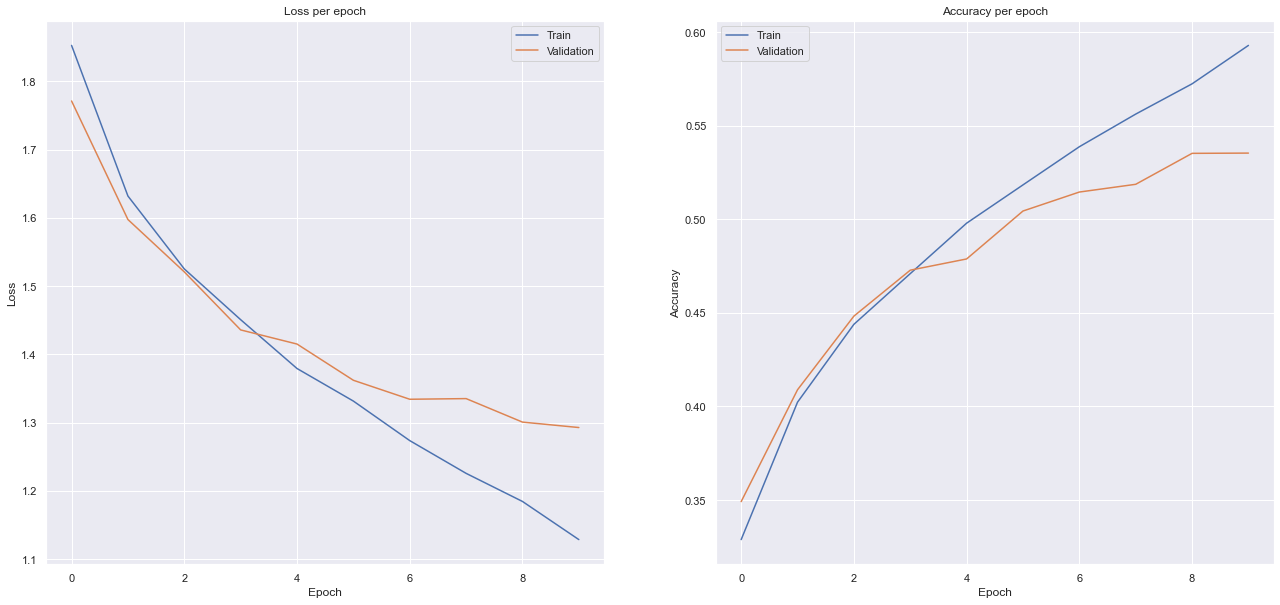

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# plot training and validation loss
ax1.plot(train_loss_history, label='Train')
ax1.plot(val_loss_history, label='Validation')
ax1.set_title('Loss per epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# plot training and validation accuracy
ax2.plot(train_acc_history, label='Train')
ax2.plot(val_acc_history, label='Validation')
ax2.set_title('Accuracy per epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

The graph shows a convergence in the validation loss, but the model got relatively poor results. <br>
Initially, I got a Validation Accuracy of around 50%, and the convergence was slow, so I added a norm layer to the model and increased the LR from 0.0001 to 0.001. <br>
We can see here a slight improvement but not something significant. Maybe it is due to the small training set. 

# Evaluation 

In [14]:
# Calculate the accuracy of the final model on the test set.

In [23]:
model.eval()
test_loss = 0.0
test_corrects = 0

for i, data in enumerate(test_loader):
    # Get inputs and labels
    inputs, labels = data

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Track validation loss and accuracy
    test_loss += loss.item() * inputs.size(0)
    _, preds = torch.max(outputs.data, 1)
    test_corrects += torch.sum(preds == labels.data)



# Track validation loss and accuracy history
test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects / len(test_loader.dataset)

print(f"Test loss: {test_loss}\tTest accuracy: {test_acc}")

Test loss: 1.3064183320999145	Test accuracy: 0.522599995136261


# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** Since the input image is divided into a set of fixed-size patches, and each patch is treated as a separate token, the patch's relationship is lost (which patches were close together in the original image). Therefore, positional embedding plays a significant role in helping the model understand the spatial relationships between the different patches of an image. Furthermore, understanding the relationships between the patches allows the model to make better predictions.

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:** If the number of samples per class is not balanced, using accuracy as a metric for evaluating the model's performance won't be the best choice since the model would not capture the imbalance in the data. This is because the model may perform well on the majority class but poorly on the minority classes. 

We can use different methods to solve it, such as: <br>
Data augmentation: Augmenting the minority class data with different transformations will increase the number of samples from the minority classes. <br>
Class weights: assign higher weights to the minority class during training so the model pays more attention to these samples.
